# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 1: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import random
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage, misc
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [2]:
############ Store names of signs in list ##################
with open('signnames.csv') as csvfile:
    readCSV = csv.reader(csvfile)
    classID = []
    signs =[]
    count = 0
    for row in readCSV:
        if count == 0:
            count += 1
            continue
        else:
            classID.append(row[0])
            signs.append(row[1])

---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import statistics
n_train = len(X_train)

# TODO: Number of validation examples
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Visualizing Train Data Set Examples

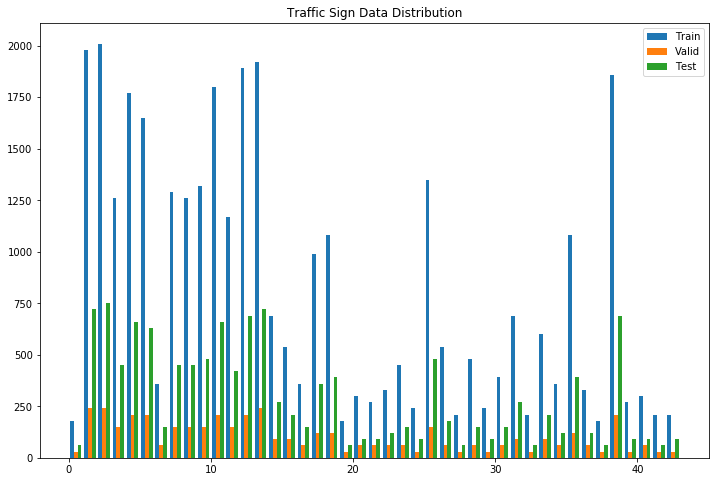

In [4]:
bins = np.arange(0,44,1).tolist()

histogram = np.histogram(y_train, bins=bins)
#print(histogram[0])
#print(histogram[1])
fig = plt.figure(figsize=(12,8))
plt.hist([y_train, y_valid, y_test], bins = bins, label=['Train', 'Valid', 'Test']) 
plt.title("Traffic Sign Data Distribution")
plt.legend(loc='upper right')
plt.show()
fig.savefig('Writeup_images/Data_set_histogram.png')

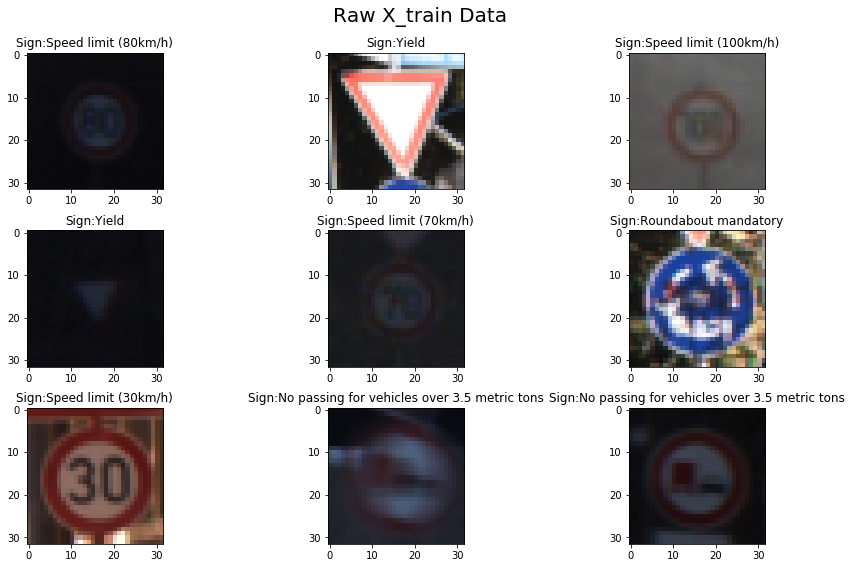

In [5]:
cols = 3
rows = 3
fig = plt.figure(figsize=(12,8))
fig.suptitle('Raw X_train Data', fontsize=20) 

for i in range(1,rows*cols+1):
    index = random.randint(0,len(X_train))
    label = y_train[index]
    ax = fig.add_subplot(rows,cols,i)
    ax.set_title('Sign:{}'.format(signs[label]))
    plt.imshow(X_train[index])
      
fig.tight_layout()
fig.subplots_adjust(top=0.9)  
fig.savefig('Writeup_images/Raw_Training_Data.png')

## Step 2: Increase Data set and Distribution

In [6]:
################### Increase data set size ############################
from scipy import ndimage
import random
add_images = []
add_y = []
histogram = np.histogram(y_train, bins=bins)

min_val = 1500
for i in range(len(histogram[1])-1):
    curr_val = histogram[0][i]
    while curr_val < min_val:
        for j in range(n_train):
            if curr_val == min_val:
                #print(curr_val)
                break
            else:
                if y_train[j] == i:
                    copy = X_train[j]
                    add_images.append(copy)
                    add_y.append(y_train[j])
                    curr_val +=1          
    
print('Number of images to be added to overall data set: ', len(add_images))



Number of images to be added to overall data set:  32581


### Visualize new distrubution of increased data set

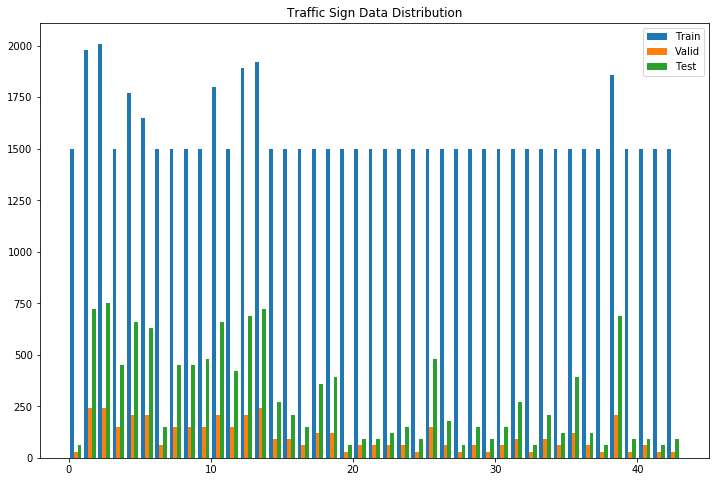

In [7]:
add_images = np.array(add_images)
add_y = np.array(add_y)
X_train_new = np.concatenate((X_train, add_images), axis=0)
y_train_new = np.concatenate((y_train, add_y), axis=0)

X_train = X_train_new
y_train = y_train_new

bins = np.arange(0,44,1).tolist()


#print(histogram[0])
#print(histogram[1])
#plt.hist(y_train, bins = bins) 
#plt.title("histogram") 
#plt.show()
plt.figure(figsize=(12,8))
plt.hist([y_train, y_valid, y_test], bins = bins, label=['Train', 'Valid', 'Test']) 
plt.title("Traffic Sign Data Distribution")
plt.legend(loc='upper right')
plt.show()
fig.savefig('Writeup_images/New_Data_set_histogram.png')

## Step 3: Augment Data Set

#### Define functions to augment each image in the data set. 

In [8]:
def sharpen(img):
    kernel_sharpening=np.array([[-1,-1,-1],
                                [-1, 9, -1],
                                [-1,-1,-1]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)
    return sharpened

def rand_rot(image):
    image = ndimage.rotate(image, angle=random.randint(-5,5), reshape=False)
    return image

def rand_translate(image):
    x = random.randint(-5,5)
    y = random.randint(-5,5)
    num_rows, num_cols = image.shape[:2]
    translate_mat = np.float32([[1,0,x], [0,1,y]])
    #image = cv2.warpAffine(image, translate_mat, (num_cols, num_rows))
    image = cv2.warpAffine(image, translate_mat, (num_cols, num_rows))
    return image

def gauss_blur(image):
    x = random.randrange(1,7,2)
    image = cv2.GaussianBlur(image,(x, x), 0)
    return image

def increase_brightness(image, value=30):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def left_warp(image):
    rows = image.shape[0]
    cols = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    
    x1 = rows/4
    x2 = 3*rows/4
    y1 = cols/4
    y2 = 3*cols/4
      
    src_points = np.float32(
    [[x1,  y2],
     [x1,  y1],
     [x2,  y1],
     [x2, y2]])

    #left tilt
    dst_points = np.float32(
    [[x1+2,  y2-3],
     [x1+2,  y1+3],
     [x2+3,  y1],
     [x2+3, y2]])
      
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
def right_warp(image):
    rows = image.shape[0]
    cols = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    
    x1 = rows/4
    x2 = 3*rows/4
    y1 = cols/4
    y2 = 3*cols/4
      
    src_points = np.float32(
    [[x1,  y2],
     [x1,  y1],
     [x2,  y1],
     [x2, y2]])
    
    #right tilt
    dst_points = np.float32(
    [[x1+2,  y2-1],
     [x1+2,  y1+1],
     [x2-3,  y1+3],
     [x2-3, y2-3]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [9]:
#Create dictionary of image augmentation functions
Augmentation = {
    'Random Rotation' : rand_rot,
    'Random Translate' : rand_translate,
    'Gaussian Blur'   : gauss_blur,
    'Brightness'     : increase_brightness,
    'Left Warp' : left_warp,
    'Right Warp' : right_warp
}

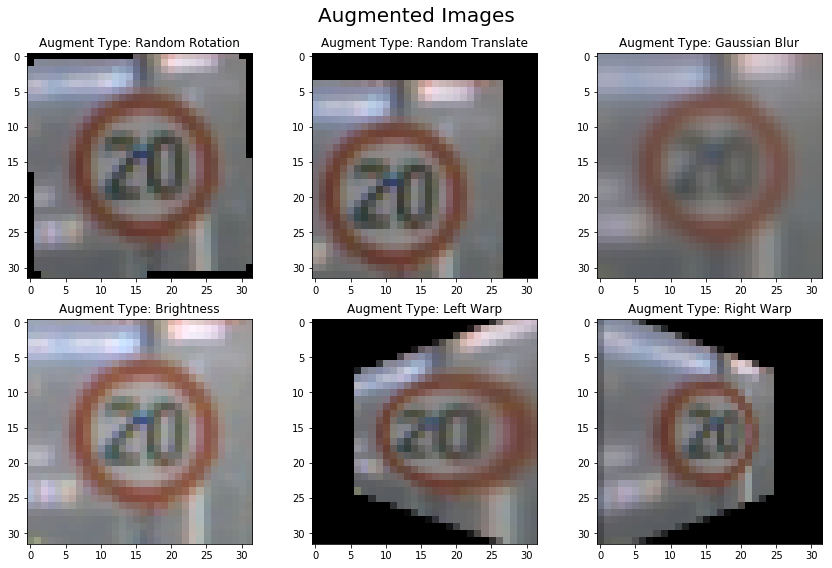

In [10]:
######### View Augmented Data types ############################
test_img = X_train[10000]
Aug_img = []
Key_name = []
for keys,values in Augmentation.items():
    new_img = Augmentation[keys](test_img)
    Aug_img.append(new_img)
    Key_name.append(keys)
        
cols = 3
rows = 2
fig = plt.figure(figsize=(12,8))
fig.suptitle('Augmented Images', fontsize=20) 

for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    ax.set_title('Augment Type: {}'.format(Key_name[i-1]))
    plt.imshow(Aug_img[i-1])
      
fig.tight_layout()
fig.subplots_adjust(top=0.9) 
fig.savefig('Writeup_images/Augmented_Data.png')

### Visualize the Image Pipeline

Show a sample of each image preprocessing step before the image is input into the model for training. 

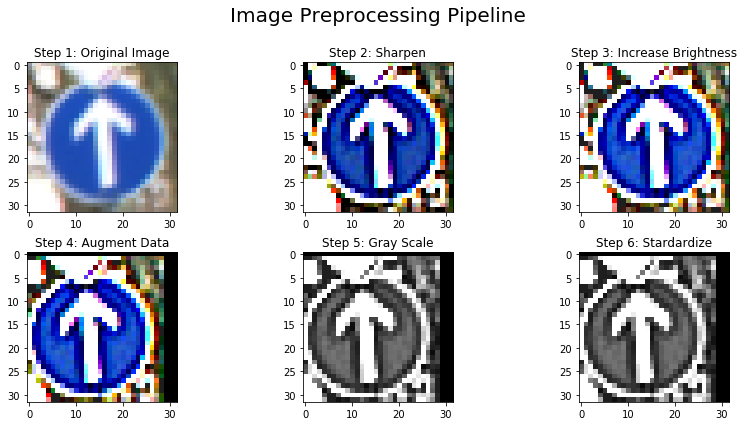

In [11]:
############### View Image Pipeline ################################
def gray(image):
    image = np.sum(image/3, axis=2, keepdims=True)
    return image.squeeze()

def standardize(image):
    image = (image - 128)/128 
    return image
    
Image_Pipeline = {
    'Sharpen' : sharpen,
    'Increase Brightness' : increase_brightness,
    'Augment Data' : rand_translate,
    'Gray Scale'   : gray,
    'Stardardize'  : standardize
}

test_img = X_train[20000]
Pipe_img = []
Key_name = []
Pipe_img.append(test_img)
Key_name.append('Original Image')

for keys,values in Image_Pipeline.items():
    count = len(Pipe_img)
    if count > 1:
        new_img = Image_Pipeline[keys](Pipe_img[count-1])
        Pipe_img.append(new_img)
        Key_name.append(keys)
    else:
        new_img = Image_Pipeline[keys](test_img)
        Pipe_img.append(new_img)
        Key_name.append(keys)

cols = 3
rows = 2
fig = plt.figure(figsize=(12,6))
fig.suptitle('Image Preprocessing Pipeline', fontsize=20) 

for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    ax.set_title('Step {}: {}'.format(i, Key_name[i-1]))
    plt.imshow(Pipe_img[i-1], cmap='gray')
      
fig.tight_layout()
fig.subplots_adjust(top=0.85) 
fig.savefig('Writeup_images/Image_Pipeline.png')

### Randomly augment every image in the data set

Using the functions I defined above, I iterate through the entire training data set and augment each individual image. Before the image is randomly augmented, I decided to sharpen and brighten each image to help improve the quality of the image being feed into the model for training. 

In [12]:
################### Randomly augment images in total data set ############################

for i in range(len(histogram[1])-1):
    # Iterate through entire data set in search of the y_label(i)
    for j in range(len(y_train)):
        # if y_labe is equal to i, then random augment that image
        if y_train[j] == i:
            ## Sharpened ang brighten each image before random augmentation
            sharp_img = sharpen(X_train[j])
            bright_img = increase_brightness(sharp_img, value=30)
            key = random.choice(list(Augmentation))
            new_image = Augmentation[key](sharp_img)
            X_train[j]= new_image

"""        

#Iterate through each y_label of the data set 
histogram = np.histogram(y_train, bins=bins)
#print('histogram check = ', histogram[0][1])
#Iterate through each y_label of the data set 
for i in range(len(histogram[1])-1):
    # Iterate through entire data set in search of the y_label(i)
    for j in range(len(y_train)):
        # if y_labe is equal to i, then random augment that image
        if y_train[j] == i:
            key = random.choice(list(Augmentation))
            new_image = Augmentation[key](X_train[j])
            X_train[j]= new_image
"""
print('finished')
print('X_train total images = ', X_train.shape[0])
#plt.imshow(X_train[5])

finished
X_train total images =  67380


### Visualize Augmented Data

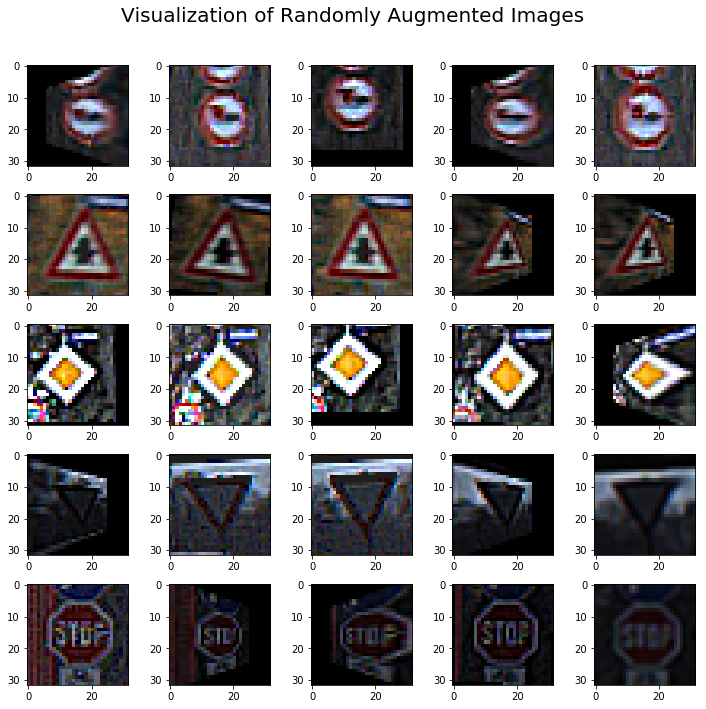

In [13]:
img_list =  []

for i in range(10,15):
    count = 0
    for j in range(len(y_train)):
        if y_train[j] == i:
            img_list.append(X_train[j])
            count += 1
        if count >=5:
            break

fig = plt.figure(figsize=(10,10))
cols = 5
rows = 5
for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    img = img_list[i-1].squeeze()
    plt.imshow(img, cmap='gray')

plt.tight_layout()
fig.suptitle('Visualization of Randomly Augmented Images', fontsize=20) 
fig.subplots_adjust(top=0.9) 
fig.savefig('Writeup_images/Random_Aug_Data.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [14]:
############## Sharpen/Brighten Validation  and Test Images ########################
for i in range(len(X_valid)):
    sharp_valid = sharpen(X_valid[i])
    bright_valid = increase_brightness(sharp_valid)
    X_valid[i] = bright_valid
    

for j in range(len(X_test)):
    sharp_test = sharpen(X_test[j])
    bright_test = increase_brightness(sharp_test)
    X_test[j] = bright_test
    
print('finished sharpening and brightening') 

finished sharpening and brightening


In [15]:
####################Convert to grayscale#############################

X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

In [16]:
###################Standardize data#####################################           
  
X_train_normalized = (X_train_gray - 128)/128 
X_valid_normalized = (X_valid_gray - 128)/128
X_test_normalized = (X_test_gray - 128)/128

print('Mean of X_train data = ', np.mean(X_train))
print('Standard Deviation of X_train data = ', np.std(X_train))
print('Mean of X_valid data = ', np.mean(X_valid))
print('Standard Deviation of X_valid data = ', np.std(X_valid))
print('Mean of X_test data = ', np.mean(X_test))
print('Standard Deviation of X_test data = ', np.std(X_test))

print('Mean of Standardized X_train data = ', np.mean(X_train_normalized))
print('Standard Deviation of Standardized X_train data = ', np.std(X_train_normalized))
print('Mean of Standardized X_valid data = ', np.mean(X_valid_normalized))
print('Standard Deviation of Standardized X_valid data = ', np.std(X_valid_normalized))
print('Mean of Standardized X_test data = ', np.mean(X_test_normalized))
print('Standard Deviation of Standardized X_test data = ', np.std(X_test_normalized))

Mean of X_train data =  74.2639593314
Standard Deviation of X_train data =  82.5361504029
Mean of X_valid data =  101.321491461
Standard Deviation of X_valid data =  85.7021919526
Mean of X_test data =  101.72623667
Standard Deviation of X_test data =  86.2899950496
Mean of Standardized X_train data =  -0.419812817723
Standard Deviation of Standardized X_train data =  0.622748240444
Mean of Standardized X_valid data =  -0.20842584796
Standard Deviation of Standardized X_valid data =  0.6292583668
Mean of Standardized X_test data =  -0.205263776017
Standard Deviation of Standardized X_test data =  0.632975009986


In [17]:
#X_train_normalized = (X_train - 255)/255 

In [18]:
"""scat_img = X_train[0]
r = scat_img[:,:,0]
g = scat_img[:,:,1]
b = scat_img[:,:,2]


fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax1.set_xlim([-255, 255])
ax1.set_ylim([-255, 255])
plt.scatter(r, g)


scat_img = X_train_normalized[0]
r = scat_img[:,:,0]
g = scat_img[:,:,1]
b = scat_img[:,:,2]

ax1 = fig.add_subplot(122)
ax1.set_xlim([-10, 10])
ax1.set_ylim([-10, 10])
plt.scatter(r, g, s=100)
plt.show()
"""

'scat_img = X_train[0]\nr = scat_img[:,:,0]\ng = scat_img[:,:,1]\nb = scat_img[:,:,2]\n\n\nfig = plt.figure(figsize=(15,4))\n\nax1 = fig.add_subplot(121)\nax1.set_xlim([-255, 255])\nax1.set_ylim([-255, 255])\nplt.scatter(r, g)\n\n\nscat_img = X_train_normalized[0]\nr = scat_img[:,:,0]\ng = scat_img[:,:,1]\nb = scat_img[:,:,2]\n\nax1 = fig.add_subplot(122)\nax1.set_xlim([-10, 10])\nax1.set_ylim([-10, 10])\nplt.scatter(r, g, s=100)\nplt.show()\n'

In [19]:
"""X_train_normalized = (X_train - 255)/255 
scat_img = X_train_normalized[0]
r = scat_img[:,:,0]
g = scat_img[:,:,1]
b = scat_img[:,:,2]
fig = plt.figure()
plt.scatter(r, g, b)
plt.show()
"""

'X_train_normalized = (X_train - 255)/255 \nscat_img = X_train_normalized[0]\nr = scat_img[:,:,0]\ng = scat_img[:,:,1]\nb = scat_img[:,:,2]\nfig = plt.figure()\nplt.scatter(r, g, b)\nplt.show()\n'

### Shuffle Training Data Set

In [20]:
####################Shuffle Data#############################
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

### Model Architecture

In [21]:
###################### CNN Model ###################

def conv2d(x,W,b, strides=1):
    x = tf.nn.conv2d(x,W,strides=[1,strides,strides,1], padding='VALID')
    x = tf.nn.bias_add(x,b)
    #x = tf.nn.relu(x)
    return x

def maxpool2d(x,k=2):
    mp = tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='VALID')
    return mp

def LeNet_OG(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean=mu, stddev=sigma)),
        'wf1': tf.Variable(tf.truncated_normal(shape = [400, 120], mean = mu, stddev=sigma)),
        'wf2': tf.Variable(tf.truncated_normal(shape = [120, 84], mean = mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84,43], mean=mu, stddev=sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bf1': tf.Variable(tf.zeros(120)),
        'bf2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(43))
    }
    
    #output_height = ceil(in_height-filter_height +1/strides)
    
    ############## Layer 1 Convolutional ######################
    #Layer1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #print(x.shape)
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    #Layer1: Activation.
    conv1 = tf.nn.relu(conv1)
    #Layer1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    #print(conv1.shape)
    ############## Layer 2 Convolutional ######################
    #Layer2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    #Layer2: Activation.
    conv2 = tf.nn.relu(conv2)
    #Layer2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    #print(conv2.shape)
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep_prob)
    ############## Layer 3 Fully Connected ######################
    #Layer3: Fully Connected. Input = 400. Output = 120.
    ful_con1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1'])
    #Layer3: Activation.
    ful_con1 = tf.nn.relu(ful_con1)
    #Layer 3: Dropout
    ful_con1 = tf.nn.dropout(ful_con1, keep_prob)
    ############## Layer 4 Fully Connected ######################
    #Layer4: Fully Connected. Input = 120. Output = 84.
    ful_con2 = tf.add(tf.matmul(ful_con1, weights['wf2']), biases['bf2'])
    #Layer4: Activation.
    ful_con2 = tf.nn.relu(ful_con2)
    #Layer5: Dropout
    ful_con2 = tf.nn.dropout(ful_con2, keep_prob)
    ############## Layer 5 Fully Connected ######################
    #Layer5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(ful_con2, weights['out']), biases['out'])
    
    return logits

### Features and Labels

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x_dat')
y = tf.placeholder(tf.int32, (None), name='y_dat')
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline

In [23]:
######################## Hyperparameters #####################################
rate = 0.001
EPOCHS = 15
BATCH_SIZE = 64
#keep_prob = 0.5

print('learning rate = ', rate)
print('epochs = ', EPOCHS)
print('batch size = ', BATCH_SIZE)
#print('dropout rate = ', keep_prob)

######################## Training Pipeline ###################################
logits = LeNet_OG(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)




learning rate =  0.001
epochs =  15
batch size =  64


### Model Evaluation

In [24]:
######################## Model Evaluation ###################################
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    #initialize empty list to store validation accuracy
    acc_list = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.85})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.849

EPOCH 2 ...
Validation Accuracy = 0.907

EPOCH 3 ...
Validation Accuracy = 0.926

EPOCH 4 ...
Validation Accuracy = 0.926

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.935

EPOCH 7 ...
Validation Accuracy = 0.940

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.948

EPOCH 10 ...
Validation Accuracy = 0.951

EPOCH 11 ...
Validation Accuracy = 0.944

EPOCH 12 ...
Validation Accuracy = 0.959

EPOCH 13 ...
Validation Accuracy = 0.959

EPOCH 14 ...
Validation Accuracy = 0.955

EPOCH 15 ...
Validation Accuracy = 0.954

Model saved


## Training Accuracy vs Validation Set

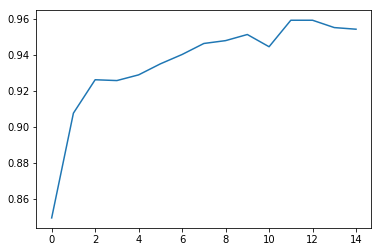

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
x_list = np.arange(len(acc_list))
plt.plot(x_list,acc_list)

## Test Model on Test Data Set

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.940


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

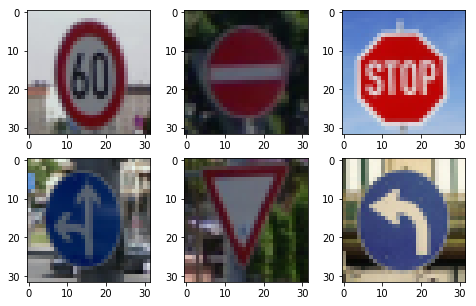

In [35]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

my_images = []
labels =[3 , 17 , 14 , 37 , 13 , 34]


for img in sorted(glob.glob('My_signs/*.PNG')):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    my_images.append(img)
    
    
fig = plt.figure(figsize=(8,5))
cols = 3
rows = 2
for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    img = my_images[i-1]
    plt.imshow(img)

fig.savefig('Writeup_images/My_German_Images.png')

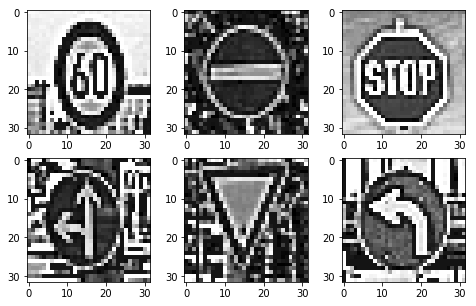

In [29]:
########### Brighten and sharpen images ############
for i in range(len(my_images)):
    sharp_valid = sharpen(my_images[i])
    bright_valid = increase_brightness(sharp_valid)
    my_images[i] = bright_valid
    
    
#Grayscale and Normalize my signs
my_images = np.array(my_images)
my_images_gray = np.sum(my_images/3, axis = 3, keepdims=True)
my_images_norm = (my_images_gray - 128)/128
    
fig2 = plt.figure(figsize=(8,5))

for i in range(1,rows*cols+1):
    ax = fig2.add_subplot(rows,cols,i)
    imgs = my_images_norm[i-1].squeeze()
    plt.imshow(imgs, cmap='gray')

### Predict the Sign Type for Each Image

In [30]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    myTest_accuracy = evaluate(my_images_norm, labels)
    print("My Test Accuracy = {:.3f}".format(myTest_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
My Test Accuracy = 1.000


### Analyze Performance

INFO:tensorflow:Restoring parameters from ./lenet
30


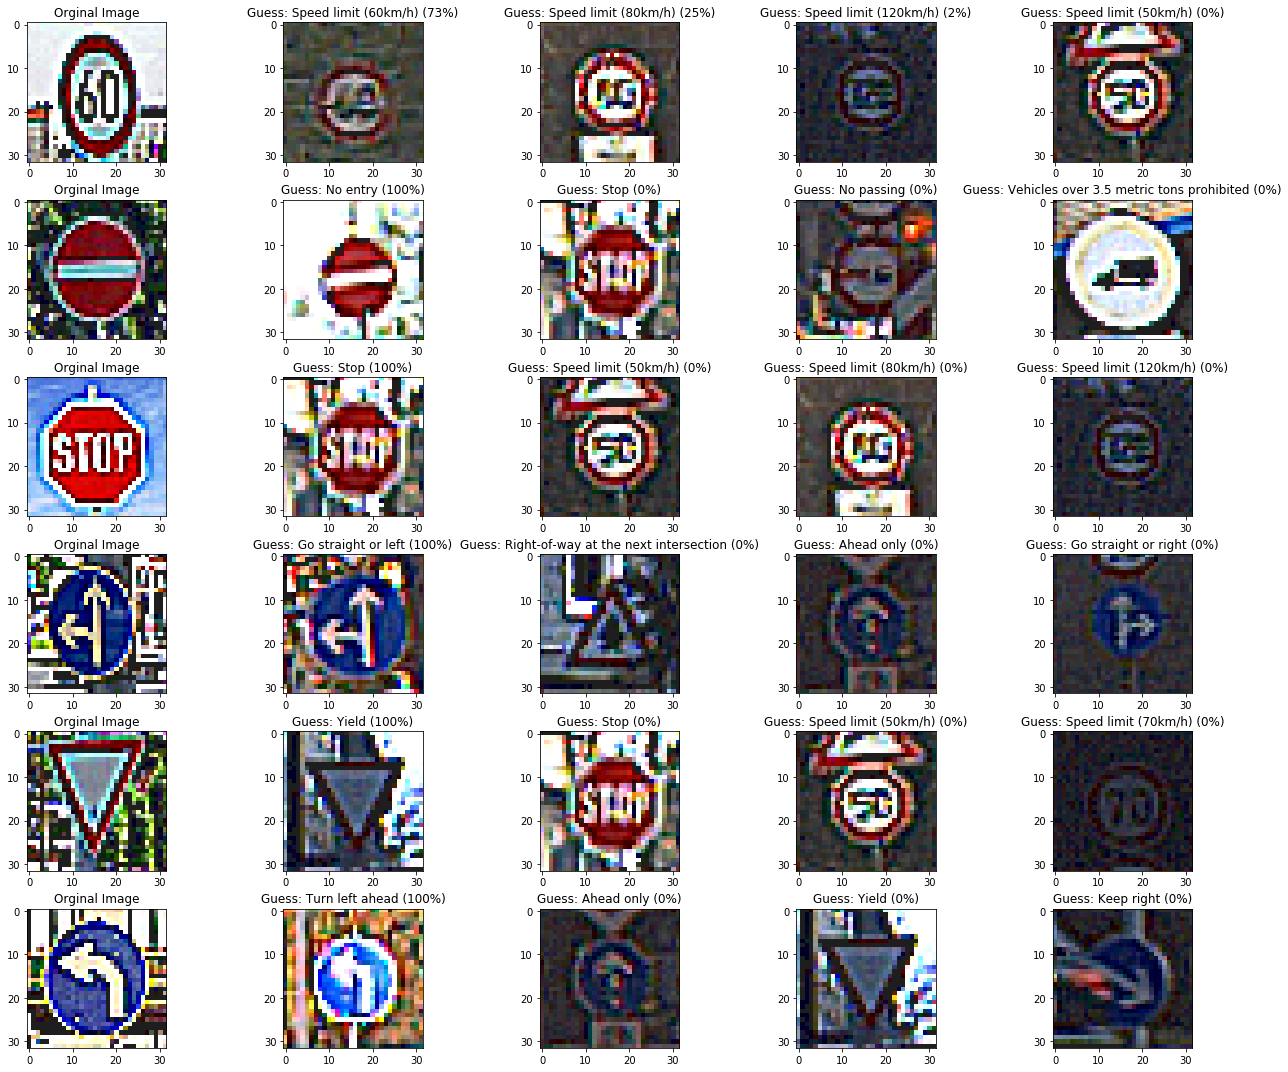

In [34]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
k_size = 4
top_k = tf.nn.top_k(softmax_logits, k=k_size)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_norm, keep_prob: 1.0})
    top_k_out = sess.run(top_k, feed_dict={x:my_images_norm, keep_prob: 1.0})
    
    TopKV, indicies = top_k_out
guess_index =[]
images =[]
guess = []
img_count = 0
for i in range(len(TopKV)): # len = 6
    for j in range(-1,k_size): # len k_size = 4
        if j == -1:
            images.append(my_images[img_count])
            guess.append(0)
            guess_index.append(0)
            img_count +=1
        else:
            guess_index.append(indicies[i][j])
            index = np.argwhere(y_valid == indicies[i][j])[0]
            images.append(X_valid[index])
            guess.append(TopKV[i][j])
            
rows = len(TopKV)
cols = k_size+1
fig3 = plt.figure(figsize=(18,15))

print(len(guess_index))

for i in range(1,rows*cols+1):
    ax = fig3.add_subplot(rows,cols,i)
    if guess[i-1] == 0:
        plot_img = images[i-1]
        ax.set_title('Orginal Image')
        guess_number = 0
    else:
        guess_number +=1
        plot_img = images[i-1]
        ind = guess_index[i-1]
        ax.set_title('Guess: {} ({:.0f}%)'.format(signs[ind], 100*guess[i-1]))
    imgs = plot_img.squeeze()
    plt.imshow(imgs,cmap='gray')
    
plt.tight_layout(pad=1.08, h_pad=0.5, w_pad=0.5, rect=None)
fig.savefig('Writeup_images/Top_SoftMax_Prob.png')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [32]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [33]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")